# Visualizations for second chapter: main economic indicators

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.gridspec import GridSpec

import seaborn as sns
from adjustText import adjust_text

import jenkspy
from shapely.geometry import Polygon

In [2]:
countries = gpd.read_file('99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')
russia = gpd.read_file('osnova_2.shp')
stavr = gpd.read_file('boundaries.geojson')

stavr = (stavr
         .query('geometry.geom_type == "Polygon" | geometry.geom_type == "MultiPolygon"')
         .loc[:, ['id', 'name', 'geometry']]
        )

countries.crs = 'EPSG:4326'
russia.crs = 'EPSG:4326'
stavr.crs = 'EPSG:4326'

In [3]:
countries = countries.to_crs(epsg=32637)
russia = russia.to_crs(epsg=32637)
stavr = stavr.to_crs(epsg=32637)

In [4]:
frame_lat = [5800000, 4600000, 4600000, 5800000]
frame_lon = [0, 0, 1500000, 1500000]

frame = Polygon(zip(frame_lon, frame_lat))
frame_gdf = gpd.GeoDataFrame([1], geometry=[frame], crs = 'EPSG:32637')

In [5]:
countries_clipped = gpd.clip(countries, frame)
russia_clipped = gpd.clip(russia, frame)

countries_clipped = countries_clipped[~countries_clipped.is_empty]
russia_clipped = russia_clipped[~russia_clipped.is_empty]

In [243]:
agri_share = pd.read_excel('agri_data.xlsx', sheet_name='доля сх')
agri_dynamics = pd.read_excel('agri_data.xlsx', sheet_name='сх в сопоставимых ценах 2009')
fondy = pd.read_excel('agri_data.xlsx', sheet_name='стоимость фондов сх')
fondy_str = pd.read_excel('agri_data.xlsx', sheet_name='структура фондов сх')
iznos = pd.read_excel('agri_data.xlsx', sheet_name='степень износа')
agri_prod = pd.read_excel('agri_data.xlsx', sheet_name='сх продукция на жителя')
agri_prod_2019 = pd.read_excel('agri_data.xlsx', sheet_name='сх на жителя 2019')

### agri_share

In [57]:
agri_share.columns

Index(['region', 2018, 'geometry', 'interval'], dtype='object')

In [176]:
agri_share = \
(gpd.GeoDataFrame(agri_share)
 .merge(russia.loc[:, ['NAMESHRT', 'geometry']], left_on='region', right_on='NAMESHRT')
 .drop('NAMESHRT', axis=1)
)

In [177]:
brks = jenkspy.jenks_breaks(agri_share[2018].tolist(), nb_class=4)
brks

[5.1, 10.2, 14.7, 19.4, 25.9]

In [178]:
brks = [5, 11, 15, 20, 26]

In [179]:
interval = pd.IntervalIndex.from_breaks(brks)

agri_share['interval'] = pd.cut(agri_share[2018], interval)

In [180]:
cmap = mpl.cm.get_cmap('Oranges_r')

legend = [mpatches.Patch(facecolor=cmap(0.8), label='Менее 5'),
          mpatches.Patch(facecolor=cmap(0.6), label='От 5 до 11'),
          mpatches.Patch(facecolor=cmap(0.3), label='От 11 до 15'),
          mpatches.Patch(facecolor=cmap(0.05), label='От 15 до 26')
         ]

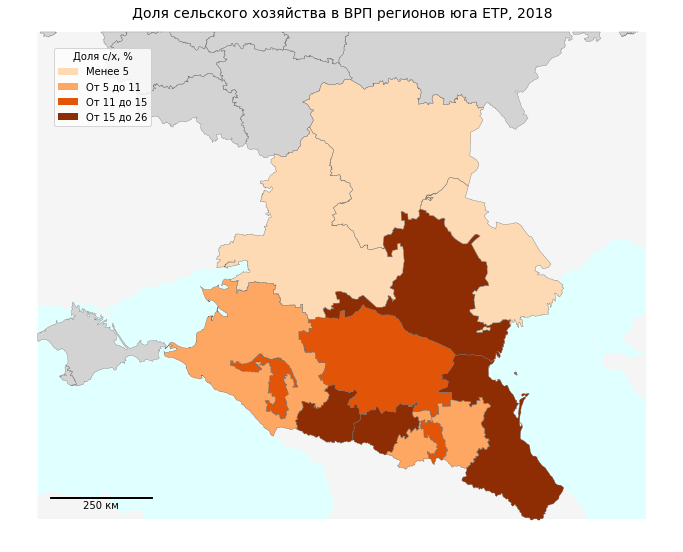

In [181]:
f, ax = plt.subplots(figsize=(12, 12))

# plotting the basemap
frame_gdf.plot(color='lightcyan', ax=ax)
countries_clipped.plot(color='whitesmoke', ax=ax)
russia_clipped.plot(color='lightgrey', ax=ax)
russia_clipped.boundary.plot(color='dimgrey', linewidth=0.3, ax=ax)

# plotting the rural data
(agri_share
 .plot(column = 2018,
       cmap = mpl.colors.ListedColormap([cmap(0.8),
                                         cmap(0.6),
                                         cmap(0.3),
                                         cmap(0.05)]),
       categorical = True,
       legend = True,
       ax = ax
      )
)

# plotting scale bar
scalebar1 = AnchoredSizeBar(ax.transData,
                           250000,
                           '250 км',
                           loc='lower center',
                           color='black',
                           frameon=False,
                           size_vertical=200,
                           bbox_to_anchor=(0.14, 0.06),
                           bbox_transform=ax.transAxes,
                           sep=3
                          )

ax.add_artist(scalebar1)

# setting title, legend, turning off axis
ax.set_title('Доля сельского хозяйства в ВРП регионов юга ЕТР, 2018', x=0.5, y=0.97, fontsize=14)
ax.legend(handles=legend, title='Доля с/х, %', loc=(0.07, 0.78))
ax.set_axis_off()

plt.savefig('agri_share_grp.png', bbox_inches='tight', dpi=300)

### agri_dynamics

In [83]:
agri_dynamics_melt = \
agri_dynamics.melt(id_vars=['region'], var_name='year')

In [84]:
agri_dynamics_melt

,region,year,value
0,Дагестан,2009,47183.384100
1,Ингушетия,2009,1269.871100
2,Кабардино-Балкария,2009,10308.635700
3,Карачаево-Черкессия,2009,5864.783200
4,Северная Осетия,2009,4934.267800
...,...,...,...
65,Кабардино-Балкария,2018,12646.513420
66,Карачаево-Черкессия,2018,6263.826665
67,Северная Осетия,2018,5114.908613
68,Чечня,2018,8064.680443


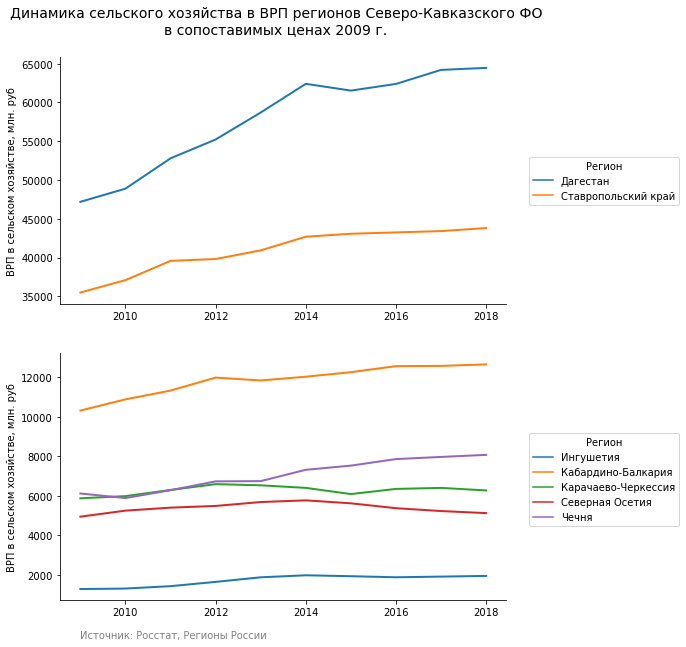

In [235]:
f, ax = plt.subplots(2, 1, figsize=(8, 10))

sns.lineplot(
    data = agri_dynamics_melt.query('region.isin(["Дагестан", "Ставропольский край"])'),
    x = 'year',
    y = 'value',
    hue = 'region',
    linewidth = 2,
    ax=ax[0]
)

ax[0].legend(loc=(1.05, 0.4), title='Регион')
ax[0].set_xlabel('')
ax[0].set_ylabel('ВРП в сельском хозяйстве, млн. руб')

sns.lineplot(
    data = agri_dynamics_melt.query('~region.isin(["Дагестан", "Ставропольский край"])'),
    x = 'year',
    y = 'value',
    hue = 'region',
    linewidth = 2,
    ax=ax[1]
)

ax[1].legend(loc=(1.05, 0.3), title='Регион')
ax[1].set_xlabel('')
ax[1].set_ylabel('ВРП в сельском хозяйстве, млн. руб')

ax[1].text(2009, -1200, 'Источник: Росстат, Регионы России', color='grey')

plt.suptitle('Динамика сельского хозяйства в ВРП регионов Северо-Кавказского ФО\nв сопоставимых ценах 2009 г.',
             x = 0.5, y = 0.95, fontsize=14
            )

sns.despine()

# plt.savefig('agri_dynamics.png', bbox_inches='tight', dpi=300)

### fondy

In [120]:
fondy_melt = \
fondy.melt(id_vars='region', var_name='year')

In [121]:
fondy_melt

,region,year,value
0,Дагестан,2017,118635
1,Ингушетия,2017,12143
2,Кабардино-Балкария,2017,40981
3,Карачаево-Черкессия,2017,28120
4,Северная Осетия,2017,11811
5,Чечня,2017,17250
6,Ставропольский край,2017,170614
7,Дагестан,2018,126076
8,Ингушетия,2018,14702
9,Кабардино-Балкария,2018,43894


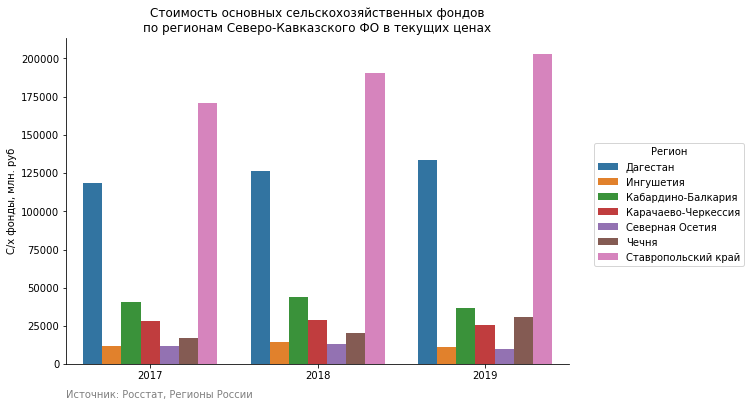

In [229]:
f, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    data = fondy_melt,
    x = 'year',
    y = 'value',
    hue = 'region'
)

plt.ylabel('С/х фонды, млн. руб')
plt.xlabel('')

plt.legend(loc=(1.05, 0.3), title='Регион')
plt.title('Стоимость основных сельскохозяйственных фондов\nпо регионам Северо-Кавказского ФО в текущих ценах')
plt.text(-0.5, -22000, 'Источник: Росстат, Регионы России', color = 'grey')

sns.despine()

# plt.savefig('fondy.png', bbox_inches='tight', dpi=300)

### fondy_str

In [130]:
fondy_str

,region,2019
0,Адыгея,5.0
1,Калмыкия,4.4
2,Краснодарский край,2.3
3,Астраханская область,2.4
4,Волгоградская область,5.3
5,Ростовская область,2.7
6,Дагестан,7.3
7,Ингушетия,6.5
8,Кабардино-Балкария,7.0
9,Карачаево-Черкессия,6.8


In [168]:
fondy_str = \
(gpd.GeoDataFrame(fondy_str)
 .merge(russia.loc[:, ['NAMESHRT', 'geometry']], left_on='region', right_on='NAMESHRT')
 .drop('NAMESHRT', axis=1)
)

In [169]:
brks = jenkspy.jenks_breaks(fondy_str[2019].tolist(), nb_class=4)
brks

[2.3, 2.7, 3.5, 5.3, 7.3]

In [170]:
brks = [2, 3, 4, 6, 8]

In [171]:
interval = pd.IntervalIndex.from_breaks(brks)

fondy_str['interval'] = pd.cut(fondy_str[2019], interval)

In [172]:
cmap = mpl.cm.get_cmap('Greens_r')

legend = [mpatches.Patch(facecolor=cmap(0.8), label='От 2 до 3'),
          mpatches.Patch(facecolor=cmap(0.6), label='От 3 до 4'),
          mpatches.Patch(facecolor=cmap(0.3), label='От 4 до 6'),
          mpatches.Patch(facecolor=cmap(0.05), label='Более 6')
         ]

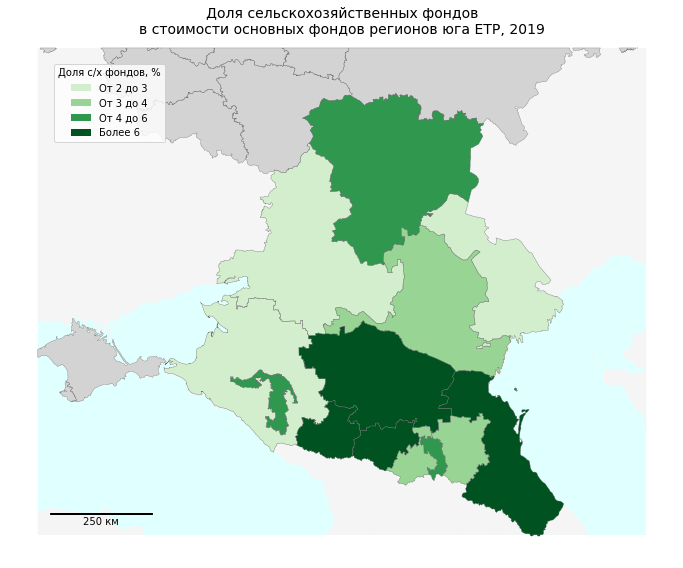

In [174]:
f, ax = plt.subplots(figsize=(12, 12))

# plotting the basemap
frame_gdf.plot(color='lightcyan', ax=ax)
countries_clipped.plot(color='whitesmoke', ax=ax)
russia_clipped.plot(color='lightgrey', ax=ax)
russia_clipped.boundary.plot(color='dimgrey', linewidth=0.3, ax=ax)

# plotting the rural data
(fondy_str
 .plot(column = 2019,
       cmap = mpl.colors.ListedColormap([cmap(0.8),
                                         cmap(0.6),
                                         cmap(0.3),
                                         cmap(0.05)]),
       categorical = True,
       legend = True,
       ax = ax
      )
)

# plotting scale bar
scalebar1 = AnchoredSizeBar(ax.transData,
                           250000,
                           '250 км',
                           loc='lower center',
                           color='black',
                           frameon=False,
                           size_vertical=200,
                           bbox_to_anchor=(0.14, 0.06),
                           bbox_transform=ax.transAxes,
                           sep=3
                          )

ax.add_artist(scalebar1)

# setting title, legend, turning off axis
ax.set_title('Доля сельскохозяйственных фондов\nв стоимости основных фондов регионов юга ЕТР, 2019',
             x=0.5,
             y=0.97,
             fontsize=14)

ax.legend(handles=legend, title='Доля с/х фондов, %', loc=(0.07, 0.78))
ax.set_axis_off()

plt.savefig('fondy_str.png', bbox_inches='tight', dpi=300)

### iznos

In [158]:
iznos

,region,2019,geometry
0,Адыгея,58.5,"POLYGON ((553103.163 5005466.288, 553268.285 5..."
1,Калмыкия,35.1,"POLYGON ((974861.099 5347059.962, 983389.809 5..."
2,Краснодарский край,44.2,"MULTIPOLYGON (((371930.956 4957504.525, 371920..."
3,Астраханская область,23.8,"MULTIPOLYGON (((1115848.153 5071946.099, 11143..."
4,Волгоградская область,34.1,"POLYGON ((759599.543 5683760.101, 761757.927 5..."
5,Ростовская область,46.3,"POLYGON ((667676.886 5565121.048, 669329.720 5..."
6,Дагестан,28.7,"MULTIPOLYGON (((1200013.951 4908317.448, 12019..."
7,Ингушетия,59.1,"POLYGON ((951616.576 4821899.306, 951945.517 4..."
8,Кабардино-Балкария,47.3,"POLYGON ((894600.612 4885762.677, 894854.622 4..."
9,Карачаево-Черкессия,42.1,"POLYGON ((727750.689 4931045.345, 730459.449 4..."


In [244]:
iznos = \
(gpd.GeoDataFrame(iznos)
 .merge(russia.loc[:, ['NAMESHRT', 'geometry']], left_on='region', right_on='NAMESHRT')
 .drop('NAMESHRT', axis=1)
)

In [245]:
brks = jenkspy.jenks_breaks(iznos[2019].tolist(), nb_class=4)
brks

[13.9, 24.2, 35.1, 47.3, 59.1]

In [246]:
brks = [13, 25, 36, 50, 60]

In [247]:
interval = pd.IntervalIndex.from_breaks(brks)

iznos['interval'] = pd.cut(iznos[2019], interval)

In [248]:
cmap = mpl.cm.get_cmap('Reds_r')

legend = [mpatches.Patch(facecolor=cmap(0.8), label='От 13 до 25'),
          mpatches.Patch(facecolor=cmap(0.6), label='От 25 до 36'),
          mpatches.Patch(facecolor=cmap(0.3), label='От 36 до 50'),
          mpatches.Patch(facecolor=cmap(0.05), label='Более 50')
         ]

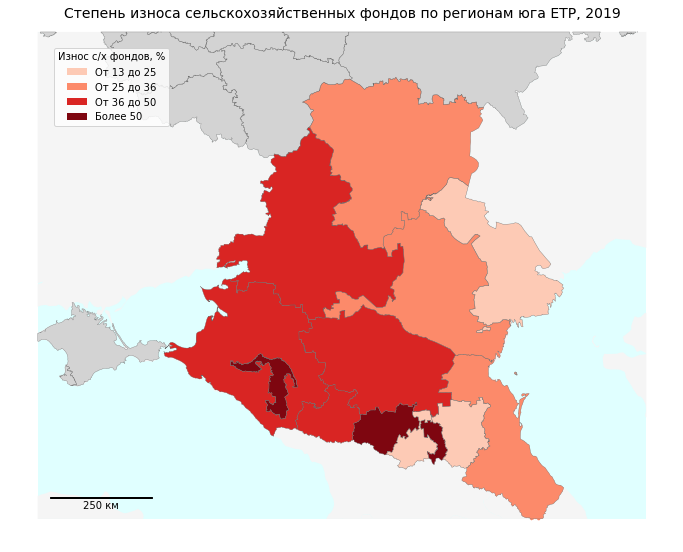

In [249]:
f, ax = plt.subplots(figsize=(12, 12))

# plotting the basemap
frame_gdf.plot(color='lightcyan', ax=ax)
countries_clipped.plot(color='whitesmoke', ax=ax)
russia_clipped.plot(color='lightgrey', ax=ax)
russia_clipped.boundary.plot(color='dimgrey', linewidth=0.3, ax=ax)

# plotting the rural data
(iznos
 .plot(column = 2019,
       cmap = mpl.colors.ListedColormap([cmap(0.8),
                                         cmap(0.6),
                                         cmap(0.3),
                                         cmap(0.05)]),
       categorical = True,
       legend = True,
       ax = ax
      )
)

# plotting scale bar
scalebar1 = AnchoredSizeBar(ax.transData,
                           250000,
                           '250 км',
                           loc='lower center',
                           color='black',
                           frameon=False,
                           size_vertical=200,
                           bbox_to_anchor=(0.14, 0.06),
                           bbox_transform=ax.transAxes,
                           sep=3
                          )

ax.add_artist(scalebar1)

# setting title, legend, turning off axis
ax.set_title('Степень износа сельскохозяйственных фондов по регионам юга ЕТР, 2019',
             x=0.5,
             y=0.97,
             fontsize=14)

ax.legend(handles=legend, title='Износ с/х фондов, %', loc=(0.07, 0.78))
ax.set_axis_off()

plt.savefig('iznos.png', bbox_inches='tight', dpi=300)

### agri_prod

In [182]:
agri_prod

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Дагестан,25774.703717,27487.200216,28116.933943,29073.047899,29810.200812,30532.986064,31449.837629,33156.426429,33726.185114,34614.002496,37609.751624,39079.273694,41019.481740,42883.082837,43025.980313
1,Ингушетия,19163.616349,17891.423797,18709.106297,18113.098108,20680.132262,21104.823383,20944.801367,23136.830332,17888.408883,18951.645333,20053.633125,20512.278986,22769.976547,19606.433298,21447.630426
2,Кабардино-Балкария,35321.087998,33099.578757,33801.649412,36311.436659,39927.684518,41521.206442,45523.127963,49825.492819,52135.673523,54268.493223,54094.657664,56188.617128,58826.033265,61526.847855,63339.098351
3,Карачаево-Черкессия,47571.652609,48002.674005,50188.440591,51678.014641,55067.014818,58026.206894,56632.066639,62904.965612,62530.154631,66402.788949,62898.000414,66857.436946,68229.978269,67893.382901,68956.185567
4,Северная Осетия,45111.474059,42467.997765,41774.266099,43734.991413,56760.042456,54005.207625,55456.578585,57991.373710,58953.548554,59526.341767,54057.590421,47313.492996,43069.186436,41939.580972,45787.136513
5,Чечня,14385.600359,14923.469811,16781.736644,19224.526538,20225.340999,19937.341756,19416.318953,19619.691405,18446.064851,19460.419172,18819.326341,19668.794152,21214.095952,23308.801003,22289.140210
6,Ставропольский край,49595.257581,54297.039656,52385.096790,54120.881029,61495.312210,55352.592430,56695.962083,65989.218837,52655.528396,61615.198826,65289.692029,67582.205747,74353.689556,73728.539253,70301.850397


In [184]:
agri_prod_melt = \
agri_prod.melt(id_vars='region', var_name='year')

In [185]:
agri_prod_melt

,region,year,value
0,Дагестан,2005,25774.703717
1,Ингушетия,2005,19163.616349
2,Кабардино-Балкария,2005,35321.087998
3,Карачаево-Черкессия,2005,47571.652609
4,Северная Осетия,2005,45111.474059
...,...,...,...
100,Кабардино-Балкария,2019,63339.098351
101,Карачаево-Черкессия,2019,68956.185567
102,Северная Осетия,2019,45787.136513
103,Чечня,2019,22289.140210


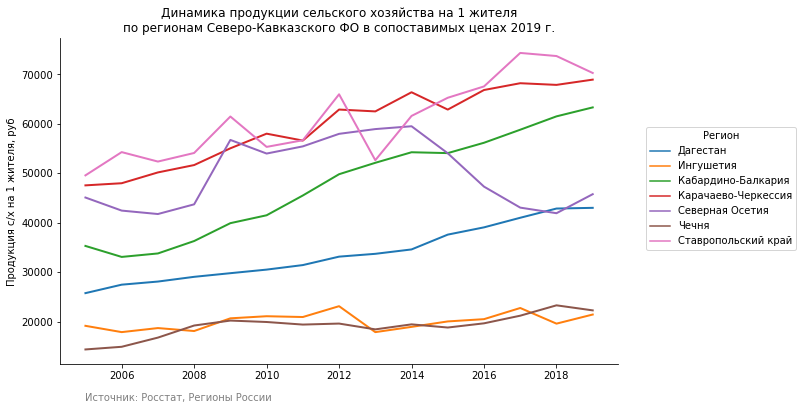

In [222]:
f, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data = agri_prod_melt,
    x = 'year',
    y = 'value',
    hue = 'region',
    linewidth = 2,
    ax=ax
)

ax.legend(loc=(1.05, 0.35), title='Регион')
ax.set_xlabel('')
ax.set_ylabel('Продукция с/х на 1 жителя, руб')

plt.title('Динамика продукции сельского хозяйства на 1 жителя\nпо регионам Северо-Кавказского ФО в сопоставимых ценах 2019 г.')
plt.text(2005, 4000, 'Источник: Росстат, Регионы России', color='grey')

sns.despine()

# plt.savefig('agri_prod_dynamics.png', bbox_inches='tight', dpi=300)

### agri_prod_2019

In [198]:
agri_prod_2019

,region,2019
0,Адыгея,55110.045762
1,Калмыкия,102504.597278
2,Краснодарский край,73686.990003
3,Астраханская область,49915.833251
4,Волгоградская область,59663.905894
5,Ростовская область,67963.858003
6,Дагестан,43025.980313
7,Ингушетия,21447.630426
8,Кабардино-Балкария,63339.098351
9,Карачаево-Черкессия,68956.185567


In [203]:
agri_prod_2019 = \
(gpd.GeoDataFrame(agri_prod_2019)
 .merge(russia.loc[:, ['NAMESHRT', 'geometry']], left_on='region', right_on='NAMESHRT')
 .drop('NAMESHRT', axis=1)
)

In [205]:
brks = jenkspy.jenks_breaks(agri_prod_2019[2019].tolist(), nb_class=4)
brks

[21447.630426125048,
 22289.140209837853,
 55110.04576160383,
 73686.9900031792,
 102504.59727841118]

In [207]:
brks = [21000, 23000, 55000, 75000, 105000]

In [208]:
interval = pd.IntervalIndex.from_breaks(brks)

agri_prod_2019['interval'] = pd.cut(agri_prod_2019[2019], interval)

In [210]:
cmap = mpl.cm.get_cmap('Greens_r')

legend = [mpatches.Patch(facecolor=cmap(0.8), label='От 21 до 23'),
          mpatches.Patch(facecolor=cmap(0.6), label='От 23 до 55'),
          mpatches.Patch(facecolor=cmap(0.3), label='От 55 до 75'),
          mpatches.Patch(facecolor=cmap(0.05), label='От 75 до 105')
         ]

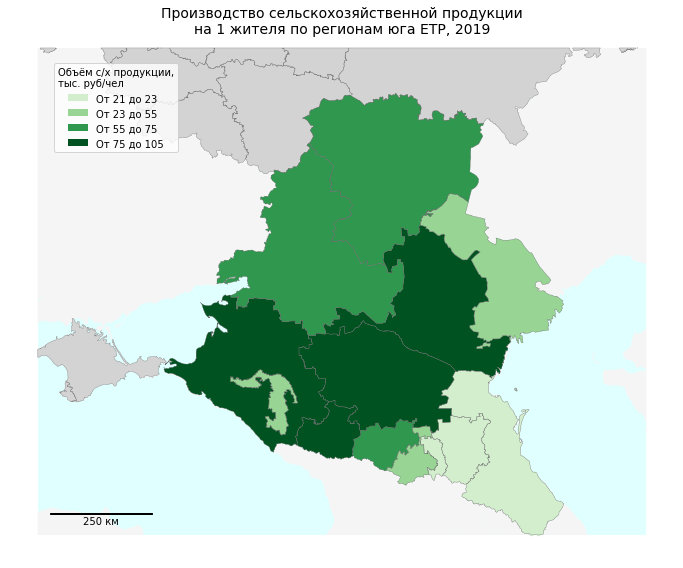

In [215]:
f, ax = plt.subplots(figsize=(12, 12))

# plotting the basemap
frame_gdf.plot(color='lightcyan', ax=ax)
countries_clipped.plot(color='whitesmoke', ax=ax)
russia_clipped.plot(color='lightgrey', ax=ax)
russia_clipped.boundary.plot(color='dimgrey', linewidth=0.3, ax=ax)

# plotting the rural data
(agri_prod_2019
 .plot(column = 2019,
       cmap = mpl.colors.ListedColormap([cmap(0.8),
                                         cmap(0.6),
                                         cmap(0.3),
                                         cmap(0.05)]),
       categorical = True,
       legend = True,
       ax = ax
      )
)

# plotting scale bar
scalebar1 = AnchoredSizeBar(ax.transData,
                           250000,
                           '250 км',
                           loc='lower center',
                           color='black',
                           frameon=False,
                           size_vertical=200,
                           bbox_to_anchor=(0.14, 0.06),
                           bbox_transform=ax.transAxes,
                           sep=3
                          )

ax.add_artist(scalebar1)

# setting title, legend, turning off axis
ax.set_title('Производство сельскохозяйственной продукции\nна 1 жителя по регионам юга ЕТР, 2019',
             x=0.5,
             y=0.97,
             fontsize=14)

ax.legend(handles=legend, title='Объём с/х продукции,\nтыс. руб/чел', loc=(0.07, 0.76))
ax.set_axis_off()

# plt.savefig('agri_prod_map.png', bbox_inches='tight', dpi=300)